# Bloom Classifier: A Flower Species Recognition System

## Exploratory Data Analysis and Model Selection

In this notebook, our primary goal is to develop an image classification model capable of identifying various types of flowers. To achieve this, we will begin by loading and exploring the flower dataset to gain valuable insights into the available information. Additionally, we will experiment with different machine learning models, leveraging a small subset of data points to evaluate their initial performance. Through this preliminary data analysis and model selection process, we aim to lay a solid foundation for building a robust and accurate Bloom Classifier. 

We start with a script to download and load the data, and perform a preliminary exploration. For now, we'll simply count the number of images in each category.

In [2]:
import os
import urllib.request
import tarfile
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split 

# Download the data
data_url = "http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
data_file = "./data/102flowers.tgz"
os.makedirs(os.path.dirname(data_file), exist_ok=True)
urllib.request.urlretrieve(data_url, data_file)


('./data/102flowers.tgz', <http.client.HTTPMessage at 0x135110e20>)

In [3]:
# Extract the data
with tarfile.open(data_file) as tar:
    tar.extractall(path='./data')

# Load the data
image_folder = './data/jpg/'
image_files = [os.path.join(image_folder, file) for file in os.listdir(image_folder)]
images = [cv2.imread(file) for file in image_files]


In [4]:
# Print the total number of images
print(f'Total number of images: {len(images)}')

Total number of images: 8189


In [5]:
# Load the labels
labels_url = "http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"
labels_file = "./data/imagelabels.mat"
urllib.request.urlretrieve(labels_url, labels_file)

('./data/imagelabels.mat', <http.client.HTTPMessage at 0x135110400>)

In [6]:
from scipy.io import loadmat
labels = loadmat(labels_file)['labels'][0] - 1  # Adjusting labels to be in the range 0-101

# Count the number of images in each category
unique, counts = np.unique(labels, return_counts=True)
label_counts = dict(zip(unique, counts))

# Print the number of images in each category
print(f'Number of images in each category: {label_counts}')


Number of images in each category: {0: 40, 1: 60, 2: 40, 3: 56, 4: 65, 5: 45, 6: 40, 7: 85, 8: 46, 9: 45, 10: 87, 11: 87, 12: 49, 13: 48, 14: 49, 15: 41, 16: 85, 17: 82, 18: 49, 19: 56, 20: 40, 21: 59, 22: 91, 23: 42, 24: 41, 25: 41, 26: 40, 27: 66, 28: 78, 29: 85, 30: 52, 31: 45, 32: 46, 33: 40, 34: 43, 35: 75, 36: 108, 37: 56, 38: 41, 39: 67, 40: 127, 41: 59, 42: 130, 43: 93, 44: 40, 45: 196, 46: 67, 47: 71, 48: 49, 49: 92, 50: 258, 51: 85, 52: 93, 53: 61, 54: 71, 55: 109, 56: 67, 57: 114, 58: 67, 59: 109, 60: 50, 61: 55, 62: 54, 63: 52, 64: 102, 65: 61, 66: 42, 67: 54, 68: 54, 69: 62, 70: 78, 71: 96, 72: 194, 73: 171, 74: 120, 75: 107, 76: 251, 77: 137, 78: 41, 79: 105, 80: 166, 81: 112, 82: 131, 83: 86, 84: 63, 85: 58, 86: 63, 87: 154, 88: 184, 89: 82, 90: 76, 91: 66, 92: 46, 93: 162, 94: 128, 95: 91, 96: 66, 97: 82, 98: 63, 99: 49, 100: 58, 101: 48}


In [3]:
import os
import urllib.request
import tarfile
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split 

# Download the data
data_url = "http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
data_file = "./data/102flowers.tgz"
os.makedirs(os.path.dirname(data_file), exist_ok=True)
urllib.request.urlretrieve(data_url, data_file)

# Extract the data
with tarfile.open(data_file) as tar:
    tar.extractall(path='./data')

# Load the data
image_folder = './data/jpg/'
image_files = [os.path.join(image_folder, file) for file in os.listdir(image_folder)]
images = [cv2.imread(file) for file in image_files]

# Print the total number of images
print(f'Total number of images: {len(images)}')

# Load the labels
labels_url = "http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"
labels_file = "./data/imagelabels.mat"
urllib.request.urlretrieve(labels_url, labels_file)

from scipy.io import loadmat
labels = loadmat(labels_file)['labels'][0] - 1  # Adjusting labels to be in the range 0-101

# Count the number of images in each category
unique, counts = np.unique(labels, return_counts=True)
label_counts = dict(zip(unique, counts))

# Print the number of images in each category
print(f'Number of images in each category: {label_counts}')


Total number of images: 8189
Number of images in each category: {0: 40, 1: 60, 2: 40, 3: 56, 4: 65, 5: 45, 6: 40, 7: 85, 8: 46, 9: 45, 10: 87, 11: 87, 12: 49, 13: 48, 14: 49, 15: 41, 16: 85, 17: 82, 18: 49, 19: 56, 20: 40, 21: 59, 22: 91, 23: 42, 24: 41, 25: 41, 26: 40, 27: 66, 28: 78, 29: 85, 30: 52, 31: 45, 32: 46, 33: 40, 34: 43, 35: 75, 36: 108, 37: 56, 38: 41, 39: 67, 40: 127, 41: 59, 42: 130, 43: 93, 44: 40, 45: 196, 46: 67, 47: 71, 48: 49, 49: 92, 50: 258, 51: 85, 52: 93, 53: 61, 54: 71, 55: 109, 56: 67, 57: 114, 58: 67, 59: 109, 60: 50, 61: 55, 62: 54, 63: 52, 64: 102, 65: 61, 66: 42, 67: 54, 68: 54, 69: 62, 70: 78, 71: 96, 72: 194, 73: 171, 74: 120, 75: 107, 76: 251, 77: 137, 78: 41, 79: 105, 80: 166, 81: 112, 82: 131, 83: 86, 84: 63, 85: 58, 86: 63, 87: 154, 88: 184, 89: 82, 90: 76, 91: 66, 92: 46, 93: 162, 94: 128, 95: 91, 96: 66, 97: 82, 98: 63, 99: 49, 100: 58, 101: 48}


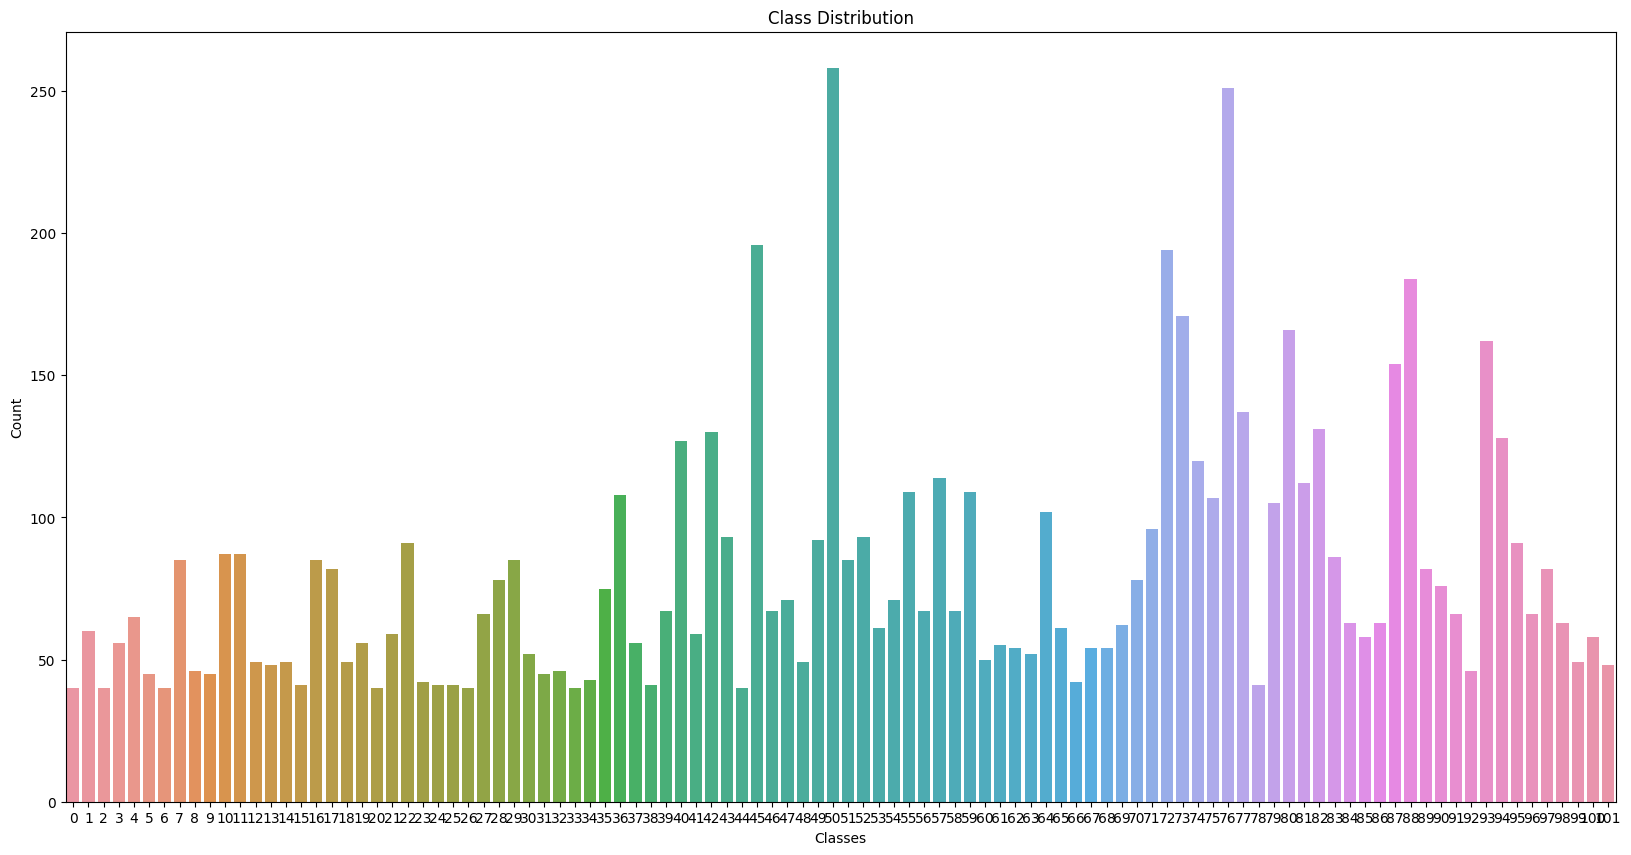

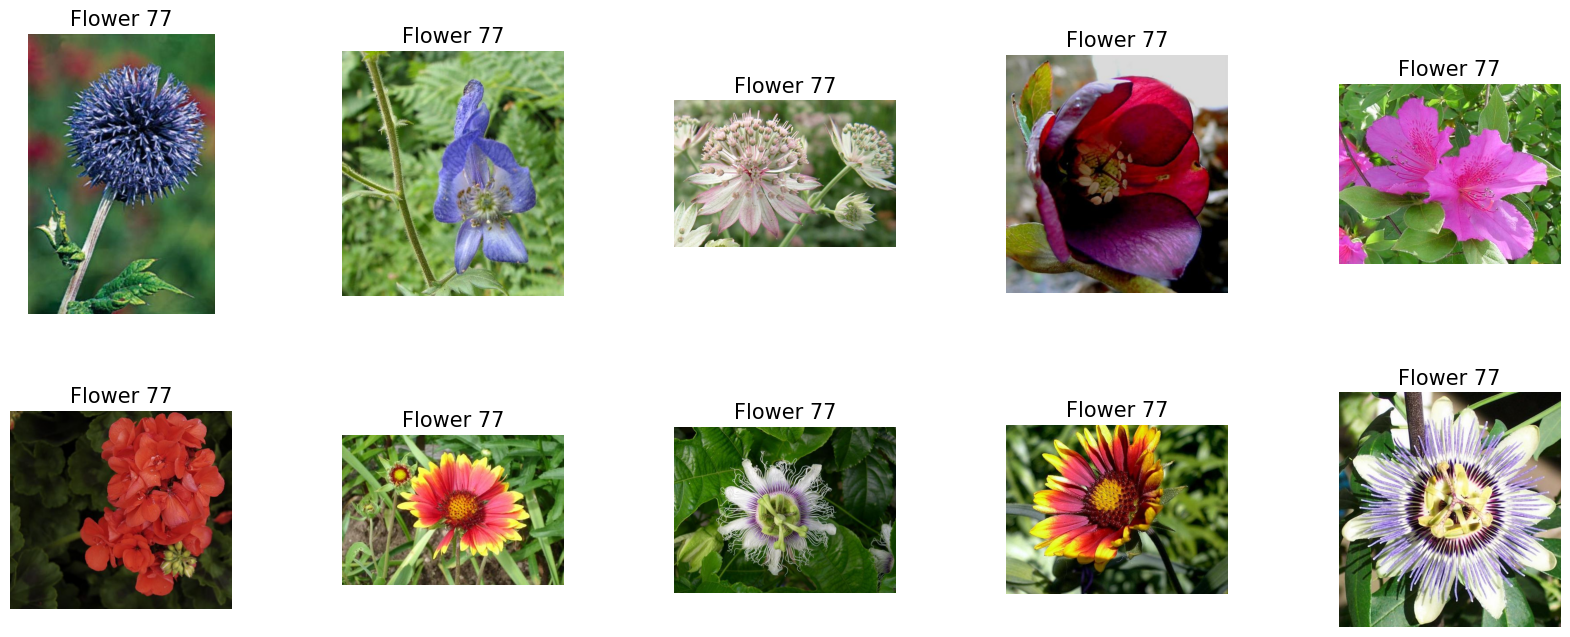

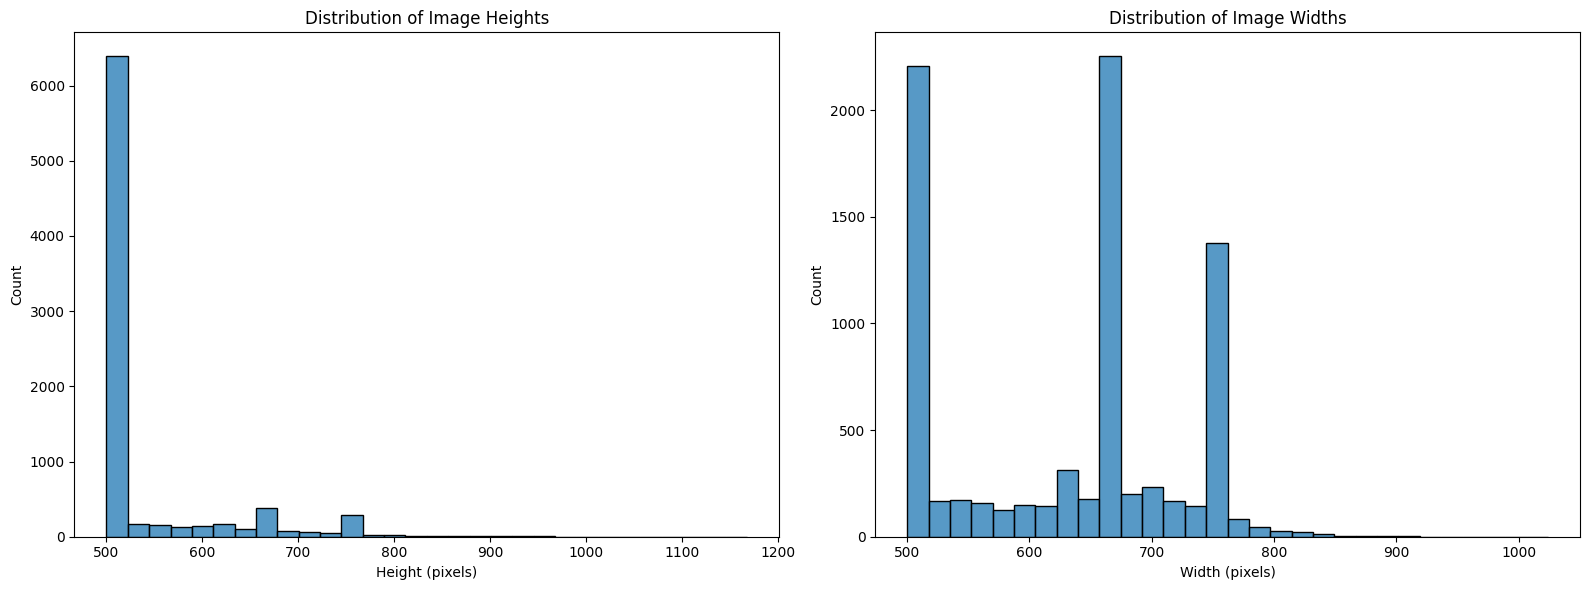

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (8189,) + inhomogeneous part.

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat

# Load the data
image_folder = './data/jpg/'
image_files = [os.path.join(image_folder, file) for file in os.listdir(image_folder)]
images = [cv2.imread(file) for file in image_files]

# Load the labels
labels_file = "./data/imagelabels.mat"
labels = loadmat(labels_file)['labels'][0] - 1  # Adjusting labels to be in the range 0-101

# Check for class imbalance
plt.figure(figsize=(20, 10))
sns.countplot(x=labels)
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

# Visualize some samples
fig, axs = plt.subplots(2, 5, figsize=(20, 8))  # Adjust this to show as many images as you need
axs = axs.ravel()

for i in np.arange(0, 10):  # Adjust this to show as many images as you need
    axs[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    axs[i].set_title(f'Flower {labels[i]+1}', fontsize=15)  # Label is +1 because we previously subtracted 1
    axs[i].axis('off')

plt.subplots_adjust(wspace=0.5)

# Check image sizes
heights = [img.shape[0] for img in images]
widths = [img.shape[1] for img in images]

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.histplot(heights, bins=30)
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.histplot(widths, bins=30)
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Examine color distributions
# For simplicity, we'll look at the distribution of color values for one randomly selected image
random_image = np.random.choice(images)

plt.figure(figsize=(16, 6))
colors = ('r', 'g', 'b')
for i, color in enumerate(colors):
    histogram = cv2.calcHist([random_image], [i], None, [256], [0, 256])
    plt.plot(histogram, color=color)
    plt.xlim([0, 256])

plt.title('Color Distribution for a Random Image')
plt.xlabel('Pixel Value')
plt.ylabel('Count')
plt.show()


Look for missing or corrupt images: You could check for missing images by checking if there are any null values in your image list after loading. To check for corrupt images, you could try opening each image file in a try/except block, and print or log any errors that come up.

In [ ]:
# Check for missing or corrupt images
missing_images = [img for img in image_files if img is None]
print(f"Number of missing images: {len(missing_images)}")

corrupt_images = []
for img_file in image_files:
    try:
        img = cv2.imread(img_file)
        cv2.imshow('image', img)
        cv2.waitKey(1)  # Displays the image for 1 ms and moves to the next image
    except Exception as e:
        corrupt_images.append(img_file)
        print(f"Corrupt image: {img_file}, error: {e}")

print(f"Number of corrupt images: {len(corrupt_images)}")

cv2.destroyAllWindows()  # Close the image display windows


Check for images not containing flowers or other potential issues: This would require manually reviewing a subset of images. Automated methods might involve more advanced techniques like outlier detection, but these are generally not foolproof.
python


In [5]:
# Randomly select a subset of images to review manually
for img_file in np.random.choice(image_files, size=100, replace=False):
    img = cv2.imread(img_file)
    cv2.imshow('image', img)
    cv2.waitKey(0)  # Wait for user to press any key before moving to the next image

cv2.destroyAllWindows()  # Close the image display windows


Check label quality: Again, this would likely involve some level of manual review. However, you could start by checking for any obvious issues like missing labels or labels that fall outside the expected range.

In [ ]:
# Check for missing labels
missing_labels = np.isnan(labels)
print(f"Number of missing labels: {np.sum(missing_labels)}")

# Check for labels outside the expected range
out_of_range_labels = (labels < 0) | (labels > 101)
print(f"Number of labels outside the expected range: {np.sum(out_of_range_labels)}")


Understanding image features usually requires some understanding of both the problem domain (in this case, flower species) and the kind of features that your model might learn to recognize.

Here are some questions you might consider:

How different are the flower species visually? If some species are very similar, the model may have difficulty distinguishing between them. Conversely, if some species are very distinctive, these could be easier for the model to learn.

What parts of the flower are visible in the images? If some images show the whole flower while others only show a part (like the petals or the center), this could affect how the model learns to recognize each species.

How much variability is there within each species? If there's a lot of variability in the appearance of a single species (due to different angles, lighting conditions, stages of growth, etc.), this could make the species harder to recognize.

Are there other distinguishing features? Beyond the flowers themselves, are there other features in the images (like leaves, stems, backgrounds, etc.) that could help the model to recognize each species?

As for code, it's difficult to write specific code to understand image features without using advanced techniques such as building a Convolutional Neural Network and examining its layers, which is beyond the scope of basic EDA. However, we can visually inspect a few random images from each class which can give us some intuition about above points.

In [ ]:
# Visualize some samples from each class
num_classes = 102  # Total number of classes
samples_per_class = 5  # Number of samples to show per class

plt.figure(figsize=(10, num_classes * 2))  # Adjust size as needed
for i in range(num_classes):
    imgs = np.random.choice(np.where(labels == i)[0], size=samples_per_class, replace=False)
    for j, img_index in enumerate(imgs):
        plt.subplot(num_classes, samples_per_class, i * samples_per_class + j + 1)
        plt.imshow(cv2.cvtColor(images[img_index], cv2.COLOR_BGR2RGB))
        plt.axis('off')
        if j == 0:
            plt.title(f'Class {i+1}')  # Label is +1 because we previously subtracted 1
plt.show()


This will give you a quick overview of what each class of flowers looks like. Looking at these images, you might be able to start forming some hypotheses about what features the model might learn to recognize, and how easy or difficult each class might be to classify.

Please note, the code above will display a large number of images which may not be feasible depending on the display size. You may want to adjust num_classes and samples_per_class to a smaller number, or create a larger plot, or scroll the plot to view all the images.

In [ ]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import torchsummary
import matplotlib.pyplot as plt
import os


model = models.resnet50(pretrained=True)

# Freeze parameters
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier
model.fc = nn.Linear(model.fc.in_features, 102)  # Number of flower classes

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

# Define your transforms for the training and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the datasets with ImageFolder
data_dir = 'path_to_your_data'  # replace with your data path
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

# Using the image datasets, define the dataloaders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=64, shuffle=True)
              for x in ['train', 'test']}




In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 20
best_acc = 0.0

for epoch in range(epochs):
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.double() / len(image_datasets[phase])

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        if phase == 'test' and epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), 'best_model.pth')

print('Best test Acc: {:4f}'.format(best_acc))
